# Load Data

##### contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [1]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
df = pd.read_excel('/users/farhan/desktop/data/practicecase/segment/online_retail.xlsx')

In [3]:
pd.set_option('display.max_rows', 25)

In [4]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [5]:
df.shape

(541909, 8)

In [6]:
## Backup
df_backup = df

# Create Description 

In [7]:
desc = {'InvoiceNo': 'A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases)',
'StockCode': 'Identifier for items contained in an invoice.',
'Description': 'Textual description of each of the stock item.',
'Quantity': 'The quantity of the item purchased.',
'InvoiceDate': 'Date of purchase.',
'UnitPrice': 'Value of each item.',
'CustomerID': 'Identifier for customer making the purchase.',
'Country': 'Country of customer.'}

In [8]:
desc = pd.DataFrame({'Column_Name': desc})

In [9]:
desc

Column_Name
Country                                   Country of customer.
CustomerID        Identifier for customer making the purchase.
Description     Textual description of each of the stock item.
InvoiceDate                                  Date of purchase.
InvoiceNo    A unique identifier for the invoice. An invoic...
Quantity                   The quantity of the item purchased.
StockCode        Identifier for items contained in an invoice.
UnitPrice                                  Value of each item.

# Data Cleaning

##### Duplicates

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(536641, 8)

##### Obvious Missing Values

In [13]:
## Checking null values in percentage format
df.isnull().sum()/df.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.270945
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.163377
Country         0.000000
dtype: float64

In [14]:
## Missing customer data is deleted, because we cant do any action even after we succesfully segment them
df.drop(index = df[df['CustomerID'].isnull()].index, inplace=True)
df.shape

(401604, 8)

In [15]:
## all the missing description came from the missing customerID
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

##### Data Types

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [17]:
## CustomerID needs to be an object
df['CustomerID'] = df['CustomerID'].astype('int')
df['CustomerID'] = df['CustomerID'].astype('str')
df['CustomerID'].dtype

dtype('O')

### Comprehensive Check

###### Invoice Number

In [18]:
df['InvoiceNo'].value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
579245       1
C537857      1
C559908      1
C550668      1
C538357      1
Name: InvoiceNo, Length: 22190, dtype: int64

In [19]:
## NON NUMERICAL VALUES CHECK IN STOCKNO, as you can see from the last query there is an abnormalities ('C')
## There is 8872 data where the invoice number contains Alphabetical 
df['InvoiceNo'].str.isdigit().value_counts()

False    8872
Name: InvoiceNo, dtype: int64

In [20]:
## Preview data with abnormalities in InvoiceNo
Invoice_check = df['InvoiceNo'].str.isdigit() == False
df.loc[Invoice_check].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice CustomerID         Country  
141 2010-12-01 09:41:00      27.50      14527  United Kingdom  
154 2010-12-01 09:49:00       4.65      15311  United Kingdom  
235 2010-12-01 10:24:00       1.65      17548  United Kingdom  
236 2010-12-01 10:24:00       0.29      17548  United Kingdom  
237 2010-12-01 10:24:00       0.29      17548  United Kingdom

In [21]:
## All the InvoceNo which contains Alphabets has NEGATIVE values Quantity
any(df.loc[Invoice_check]['Quantity']>=0)

False

In [22]:
## Checks the dataframe, checks out the same number of rows with the abnormal invoice number
df[df['Quantity'] <= 0].shape

(8872, 8)

In [23]:
##checking stock code for any reasonable excuse of negative values
negative_qty = df.loc[Invoice_check]
negative_qty[negative_qty['StockCode'].str.isalpha() == True|False]['StockCode'].unique()

array(['D', 'POST', 'M', 'CRUK'], dtype=object)

In [24]:
## D stands for discount.
discount = negative_qty[negative_qty['StockCode'] == 'D']
discount.head(2)

InvoiceNo StockCode Description  Quantity         InvoiceDate  UnitPrice  \
141    C536379         D    Discount        -1 2010-12-01 09:41:00      27.50   
9038   C537164         D    Discount        -1 2010-12-05 13:21:00      29.29   

     CustomerID         Country  
141       14527  United Kingdom  
9038      14527  United Kingdom

In [25]:
## POST stands for POSTAGE.
negative_qty_postage = negative_qty[negative_qty['StockCode'] == 'POST']
negative_qty_postage.head(2)

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
13052   C537414      POST     POSTAGE        -1 2010-12-06 15:09:00   
32383   C539063      POST     POSTAGE        -1 2010-12-15 16:50:00   

       UnitPrice CustomerID         Country  
13052       4.41      16861  United Kingdom  
32383      12.34      15107  United Kingdom

In [26]:
## However, thereis a POSTAGE with a positive quantity
any(df[df['StockCode'] == 'POST']['Quantity'] > 0)

True

In [27]:
## M stands for MANUAL.
negative_qty_mail = negative_qty[negative_qty['StockCode'] == 'M']
negative_qty_mail.head(2)

InvoiceNo StockCode Description  Quantity         InvoiceDate  \
21758   C538124         M      Manual        -4 2010-12-09 15:43:00   
29530   C538806         M      Manual        -1 2010-12-14 11:59:00   

       UnitPrice CustomerID         Country  
21758       0.50      15329  United Kingdom  
29530       4.25      15181  United Kingdom

In [28]:
## However, thereis a Manual with a positive quantity
any(df[df['StockCode'] == 'M']['Quantity'] > 0)

True

In [29]:
## CRUK stands for CRUK Commision.
## CRUK is cancer reserach based in UK
negative_qty_cruk = negative_qty[negative_qty['StockCode'] == 'CRUK']
negative_qty_cruk.head()

InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
317508   C564763      CRUK  CRUK Commission        -1 2011-08-30 10:49:00   
324023   C565382      CRUK  CRUK Commission        -1 2011-09-02 15:45:00   
333779   C566216      CRUK  CRUK Commission        -1 2011-09-09 15:17:00   
338848   C566565      CRUK  CRUK Commission        -1 2011-09-13 12:32:00   
351003   C567655      CRUK  CRUK Commission        -1 2011-09-21 14:40:00   

        UnitPrice CustomerID         Country  
317508       1.60      14096  United Kingdom  
324023      13.01      14096  United Kingdom  
333779      15.96      14096  United Kingdom  
338848      52.24      14096  United Kingdom  
351003     608.66      14096  United Kingdom

In [30]:
## now that we already understand and saved all the abnormalities, we can safely delete the negative qty
df.drop(index = df.loc[Invoice_check].index, inplace=True)
df[df['Quantity'] < 0]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

In [31]:
df.shape

(392732, 8)

In [32]:
## Check for abnormal invoice from the abnormal length

###### stock code

In [33]:
## Checking for abnormal stock code (which only contains alphabetical values)
df[df['StockCode'].str.isalpha() == True|False]['StockCode'].unique()

array(['POST', 'M', 'PADS', 'DOT'], dtype=object)

In [34]:
##Postage
pos_qty_postage = df[df['StockCode'] == 'POST']
pos_qty_postage.head(2)

InvoiceNo StockCode Description  Quantity         InvoiceDate  UnitPrice  \
45     536370      POST     POSTAGE         3 2010-12-01 08:45:00       18.0   
386    536403      POST     POSTAGE         1 2010-12-01 11:27:00       15.0   

    CustomerID      Country  
45       12583       France  
386      12791  Netherlands

In [35]:
## Manual
pos_qty_m = df[df['StockCode'] == 'M']
pos_qty_m.head(2)

InvoiceNo StockCode Description  Quantity         InvoiceDate  UnitPrice  \
2239    536569         M      Manual         1 2010-12-01 15:35:00       1.25   
2250    536569         M      Manual         1 2010-12-01 15:35:00      18.95   

     CustomerID         Country  
2239      16274  United Kingdom  
2250      16274  United Kingdom

In [36]:
## PADS
pos_qty_pads = df[df['StockCode'] == 'PADS']
pos_qty_pads.head(2)

InvoiceNo StockCode                 Description  Quantity  \
157195    550193      PADS  PADS TO MATCH ALL CUSHIONS         1   
279045    561226      PADS  PADS TO MATCH ALL CUSHIONS         1   

               InvoiceDate  UnitPrice CustomerID         Country  
157195 2011-04-15 09:27:00      0.001      13952  United Kingdom  
279045 2011-07-26 10:13:00      0.001      15618  United Kingdom

In [37]:
## DOT
pos_qty_dot = df[df['StockCode'] == 'DOT']
pos_qty_dot.head(2)

InvoiceNo StockCode     Description  Quantity         InvoiceDate  \
317507    564764       DOT  DOTCOM POSTAGE         1 2011-08-30 10:49:00   
324002    565383       DOT  DOTCOM POSTAGE         1 2011-09-02 15:45:00   

        UnitPrice CustomerID         Country  
317507      11.17      14096  United Kingdom  
324002      16.46      14096  United Kingdom

In [38]:
## DROPPING Postage, DOT as its a delivery payment, not an actual product cost
df.drop(index = pos_qty_dot.index, inplace=True)
df.drop(index = pos_qty_postage.index, inplace=True)

In [39]:
## Dropping Manual
df.drop(index = pos_qty_m.index, inplace=True)

In [40]:
## Dropping Carriage (NOT DETECTED IN THE PREVIOUS ARRAY OF ABNORMAL STOCKCODE) because its a shipping cost
pos_qty_carriage = df[df['StockCode'] == 'C2']
df.drop(index = pos_qty_carriage.index, inplace=True)

In [41]:
## Dropping BANK CHARGES (NOT DETECTED IN THE PREVIOUS ARRAY OF ABNORMAL STOCKCODE)  its not an actual product buying cost
pos_qty_bankcharge = df[df['StockCode'] == 'BANK CHARGES']
df.drop(index = pos_qty_bankcharge.index, inplace=True)

In [42]:
df.shape

(391187, 8)

###### Description

In [43]:
## No need

###### Quantity

In [44]:
##Quick check
df['Quantity'].describe()

count    391187.000000
mean         13.179541
std         181.906477
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

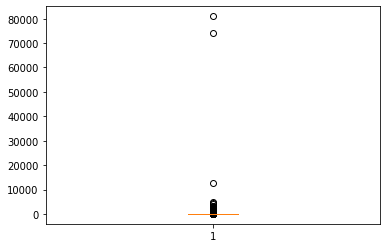

In [45]:
## Checking for outliers
plt.boxplot(df['Quantity'])
plt.show()

In [46]:
#Check for outlier data point, since most of the customer is wholeseller, hence it is REASONABLE
df[df['Quantity'] > 5000]

InvoiceNo StockCode                     Description  Quantity  \
61619     541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
502122    578841     84826  ASSTD DESIGN 3D PAPER STICKERS     12540   
540421    581483     23843     PAPER CRAFT , LITTLE BIRDIE     80995   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
502122 2011-11-25 15:57:00       0.00      13256  United Kingdom  
540421 2011-12-09 09:15:00       2.08      16446  United Kingdom

###### InvoiceDate

In [47]:
df['InvoiceDate'].sort_values()

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541896   2011-12-09 12:50:00
541895   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541900   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 391187, dtype: datetime64[ns]

###### UnitPrice

In [48]:
df['UnitPrice'].describe()

count    391187.000000
mean          2.874101
std           4.284627
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

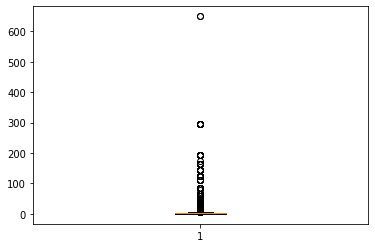

In [49]:
## Check for distribution
plt.boxplot(df['UnitPrice'])
plt.show()

In [50]:
## All abnormal values on unitprice is REASONABLE
df[df['UnitPrice'] > 100].head()

InvoiceNo StockCode                         Description  Quantity  \
246      536392     22827  RUSTIC  SEVENTEEN DRAWER SIDEBOARD         1   
4989     536835     22655         VINTAGE RED KITCHEN CABINET         1   
19428    537859     22828        REGENCY MIRROR WITH SHUTTERS         1   
19429    537859     22827  RUSTIC  SEVENTEEN DRAWER SIDEBOARD         2   
25168    538354     22826       LOVE SEAT ANTIQUE WHITE METAL         2   

              InvoiceDate  UnitPrice CustomerID         Country  
246   2010-12-01 10:29:00      165.0      13705  United Kingdom  
4989  2010-12-02 18:06:00      295.0      13145  United Kingdom  
19428 2010-12-08 16:11:00      165.0      14030  United Kingdom  
19429 2010-12-08 16:11:00      145.0      14030  United Kingdom  
25168 2010-12-10 15:45:00      175.0      16873  United Kingdom

In [51]:
## We already remove the negative price now we remove the 0 price
zero_price = df[df['UnitPrice'] <= 0]
df.drop(index = zero_price.index, inplace = True)
print('Zero price dropped, exact data set size is :',df.shape[0])

Zero price dropped, exact data set size is : 391153


## Feature Engineering 

In [52]:
df['Total'] = df['Quantity'] * df['UnitPrice']

In [53]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Total  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  15.30  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  20.34  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  22.00  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  20.34  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom  20.34

## EDA

##### What is the most sold product

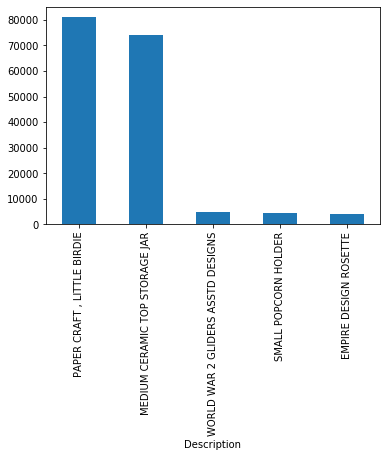

In [54]:
most_sold = pd.DataFrame(df.groupby('Description')['Quantity'].max().sort_values(ascending=False))
most_sold['Quantity'].nlargest().plot(kind = 'bar')
plt.show()

##### Monthly Transaction

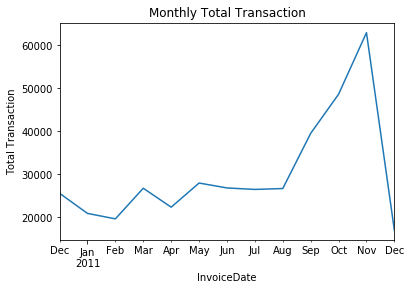

In [55]:
df.groupby(pd.Grouper(key='InvoiceDate', freq='M'))['InvoiceNo'].count().plot(kind='line')
plt.title('Monthly Total Transaction')
plt.ylabel('Total Transaction')
plt.show()

### RFM ( Recency, Frequency, Monetary Value)

###### Recency: How much time has elapsed since a customer’s last activity or transaction with the brand

###### Frequency: How often has a customer transacted or interacted with the brand during a particular period of time

######  Monetary: Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time

In [56]:
## Define last and newest transaction date
last_date = df['InvoiceDate'].min()
latest_date = last_date = df['InvoiceDate'].max()

In [57]:
## Calculating R, F, M for each customer
rfm_table = df.groupby('CustomerID').agg({
                        'InvoiceDate': lambda x: (latest_date - x.max()).days, 
                        'InvoiceNo': lambda x: len(x), 
                        'Total': lambda x: x.sum()})

rfm_table.rename(columns={'InvoiceDate': 'recency', 'InvoiceNo': 'frequency', 'Total': 'monetary_value'}, inplace=True)
rfm_table.head(3)

recency  frequency  monetary_value
CustomerID                                    
12346           325          1        77183.60
12347             1        182         4310.00
12348            74         27         1437.24

In [58]:
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [59]:
rscore = []
for f in rfm_table['recency']:
    if f <= rfm_table['recency'].quantile(0.25):
        rscore.append('1')
    elif f <= rfm_table['recency'].quantile(0.50):
        rscore.append('2')
    elif f <= rfm_table['recency'].quantile(0.75):
        rscore.append('3')
    else:
        rscore.append('4')       

In [60]:
fscore = []
for f in rfm_table['frequency']:
    if f <= rfm_table['frequency'].quantile(0.25):
        fscore.append('4')
    elif f <= rfm_table['frequency'].quantile(0.50):
        fscore.append('3')
    elif f <= rfm_table['frequency'].quantile(0.75):
        fscore.append('2')
    else:
        fscore.append('1') 

In [61]:
mscore = []
for f in rfm_table['monetary_value']:
    if f <= rfm_table['monetary_value'].quantile(0.25):
        mscore.append('4')
    elif f <= rfm_table['monetary_value'].quantile(0.50):
        mscore.append('3')
    elif f <= rfm_table['monetary_value'].quantile(0.75):
        mscore.append('2')
    else:
        mscore.append('1') 

In [62]:
rfm_table['r_score'] = rscore

In [63]:
rfm_table['f_score'] = fscore

In [64]:
rfm_table['m_score'] = mscore

In [65]:
rfm_table['RFMScore'] = rfm_table['r_score'] + rfm_table['f_score']  + rfm_table['m_score']

In [66]:
rfm_table.head(5)

recency  frequency  monetary_value r_score f_score m_score  \
CustomerID                                                               
12346           325          1        77183.60       4       4       1   
12347             1        182         4310.00       1       1       1   
12348            74         27         1437.24       3       3       2   
12349            18         72         1457.55       2       2       2   
12350           309         16          294.40       4       4       4   

           RFMScore  
CustomerID           
12346           441  
12347           111  
12348           332  
12349           222  
12350           444

In [67]:
rfm_table[rfm_table['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(5)

recency  frequency  monetary_value r_score f_score m_score  \
CustomerID                                                               
14646             1       2060       279138.02       1       1       1   
18102             0        431       259657.30       1       1       1   
17450             7        336       194390.79       1       1       1   
14911             0       5584       136161.83       1       1       1   
14156             9       1382       116560.08       1       1       1   

           RFMScore  
CustomerID           
14646           111  
18102           111  
17450           111  
14911           111  
14156           111

###### Most spending customer

# SEGMENTATION

##### In general, segmenting customer is done based on their demography, geography, behavioral, psycographic

#### Geography

###### Since this is a UK Based store, we can segment them into UK or Non UK

In [68]:
# Labeling them into UK or NON Uk resident
segment_geo = df['Country']
segment_geo = pd.DataFrame(segment_geo)
segment_geo.head(2)

Country
0  United Kingdom
1  United Kingdom

In [69]:
status = []
for f in segment_geo['Country']:
    if f == 'United Kingdom':
        status.append('UK')
    else:
        status.append('Non UK')

In [70]:
segment_geo['status'] = status
segment_geo.head(2)

Country status
0  United Kingdom     UK
1  United Kingdom     UK

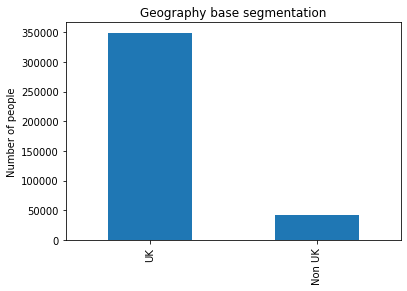

In [71]:
segment_geo['status'].value_counts().plot(kind='bar')
plt.ylabel('Number of people')
plt.title('Geography base segmentation')
plt.show()

# Segmentation

In [72]:
rfm_table

recency  frequency  monetary_value r_score f_score m_score  \
CustomerID                                                               
12346           325          1        77183.60       4       4       1   
12347             1        182         4310.00       1       1       1   
12348            74         27         1437.24       3       3       2   
12349            18         72         1457.55       2       2       2   
12350           309         16          294.40       4       4       4   
...             ...        ...             ...     ...     ...     ...   
18280           277         10          180.60       4       4       4   
18281           180          7           80.82       4       4       4   
18282             7         12          178.05       1       4       4   
18283             3        719         2039.58       1       1       1   
18287            42         70         1837.28       2       2       1   

           RFMScore  
CustomerID           
12346           441  
12347           111  
12348           332  
12349           222  
12350           444  
...             ...  
18280           444  
18281           444  
18282           144  
18283           111  
18287           221  

[4334 rows x 7 columns]

In [73]:
rfm_table.describe()

recency    frequency  monetary_value
count  4334.000000  4334.000000     4334.000000
mean     91.703046    90.252192     2015.973153
std     100.177047   224.708497     8903.673825
min       0.000000     1.000000        3.750000
25%      17.000000    17.000000      304.240000
50%      50.000000    41.000000      662.565000
75%     142.000000    98.000000     1631.622500
max     373.000000  7667.000000   279138.020000

In [74]:
#checking distribution
print('recency skew :',rfm_table['recency'].skew())
print('frequency skew :',rfm_table['frequency'].skew())
print('monetary_value skew :',rfm_table['monetary_value'].skew())

recency skew : 1.2429343497012655
frequency skew : 18.012768535075008
monetary_value skew : 19.578006249188103


In [75]:
X = rfm_table.drop(columns = ['RFMScore','r_score','f_score','m_score'])
X.head()

recency  frequency  monetary_value
CustomerID                                    
12346           325          1        77183.60
12347             1        182         4310.00
12348            74         27         1437.24
12349            18         72         1457.55
12350           309         16          294.40

In [76]:
## We need to scale the data

scaler = PowerTransformer()
X = scaler.fit_transform(X)

In [77]:
pd.DataFrame(X).describe()

0             1             2
count  4.334000e+03  4.334000e+03  4.334000e+03
mean  -1.277115e-16 -1.569016e-16  2.538092e-16
std    1.000115e+00  1.000115e+00  1.000115e+00
min   -2.116392e+00 -2.427183e+00 -5.047701e+00
25%   -7.136391e-01 -6.718388e-01 -6.592800e-01
50%   -6.486549e-03  7.917745e-03 -6.779450e-03
75%    8.332348e-01  6.974441e-01  6.950645e-01
max    1.765751e+00  4.220608e+00  3.779343e+00

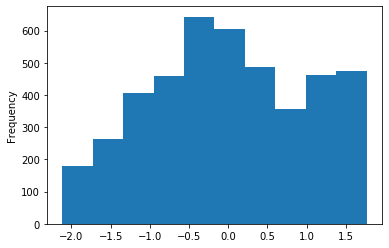

In [78]:
pd.DataFrame(X)[0].plot(kind='hist')

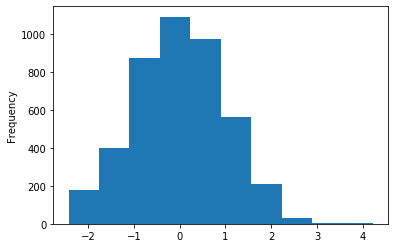

In [79]:
pd.DataFrame(X)[1].plot(kind='hist')

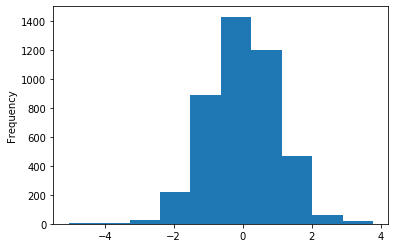

In [80]:
pd.DataFrame(X)[2].plot(kind='hist')

In [81]:
# initialization as k-means++ with 2 INITIAL K
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [82]:
## Checking inertia of INITIAL K
kmeans.inertia_

6737.009315923787

Text(0, 0.5, 'Inertia')

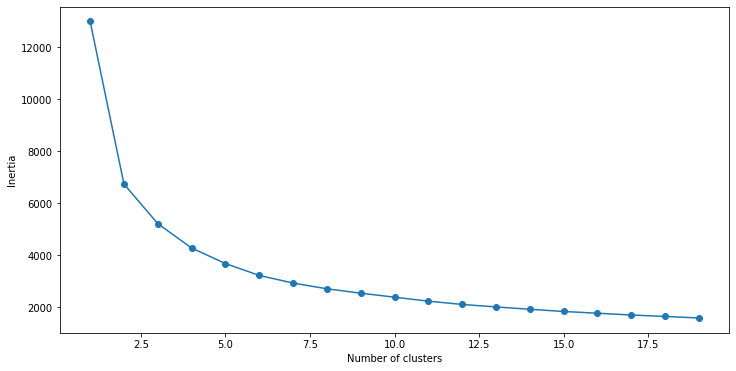

In [83]:
# Elbow method for k value checking
SSE = []
for cluster in range(1,20):
    elbow = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++', random_state = 7)
    elbow.fit(X)
    SSE.append(elbow.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

For n_clusters = 2 The average silhouette_score is : 0.39651621385224844
For n_clusters = 3 The average silhouette_score is : 0.29993695894258854
For n_clusters = 4 The average silhouette_score is : 0.304301736826054
For n_clusters = 5 The average silhouette_score is : 0.27627424529080935
For n_clusters = 6 The average silhouette_score is : 0.27650277334392453


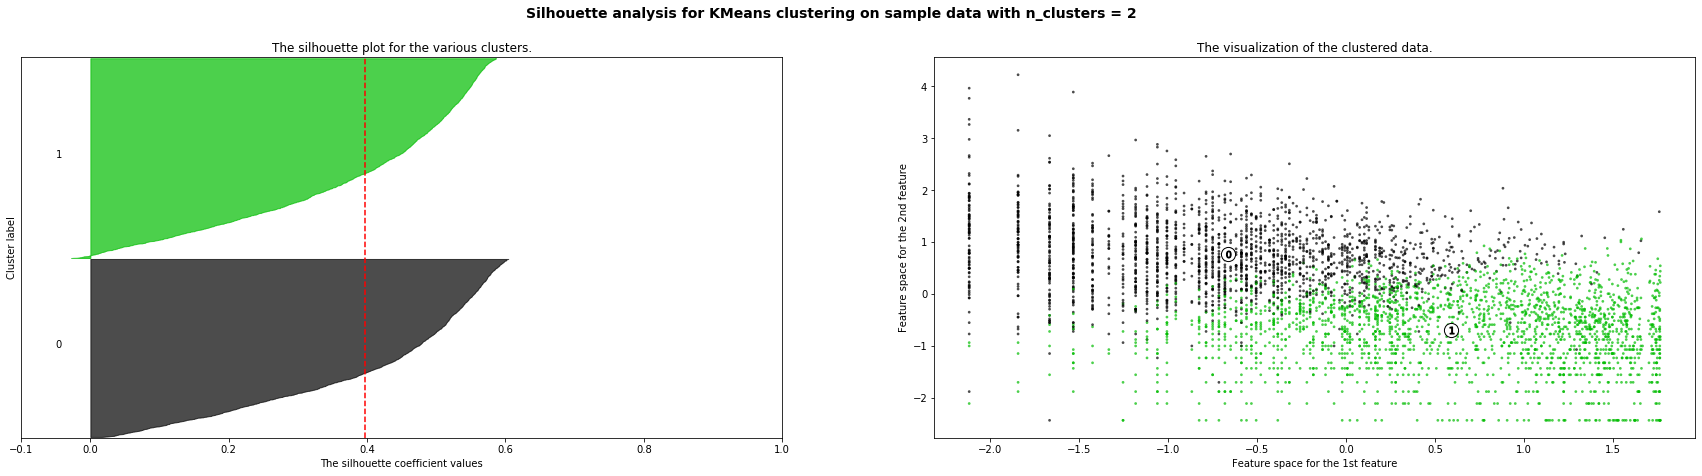

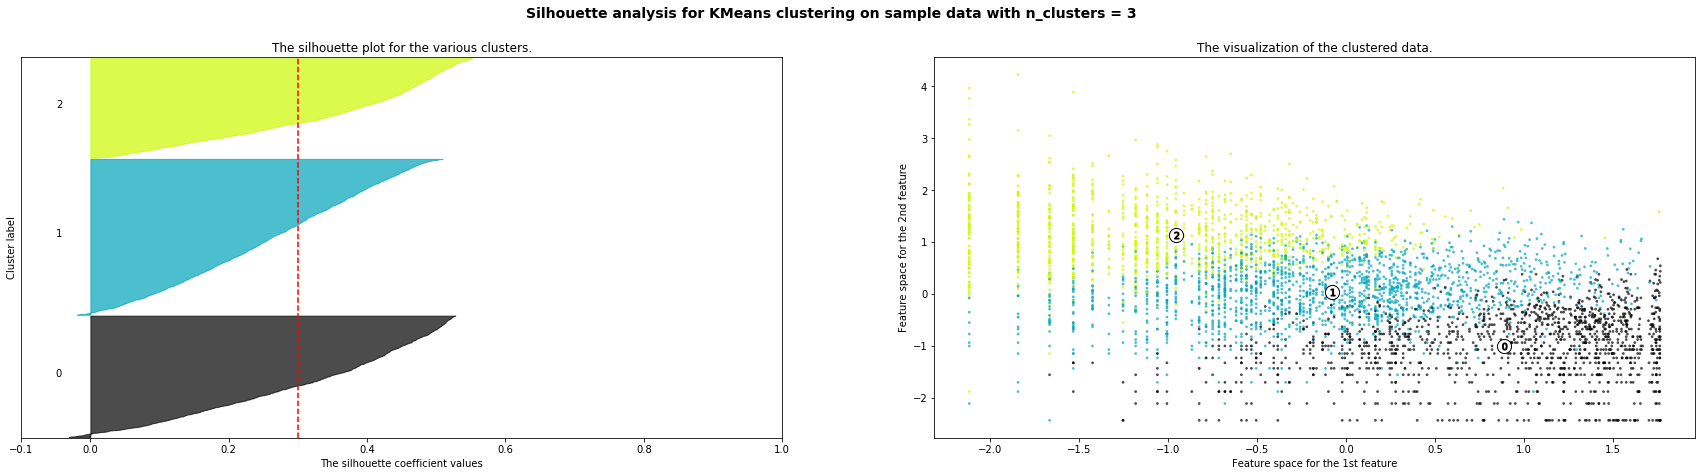

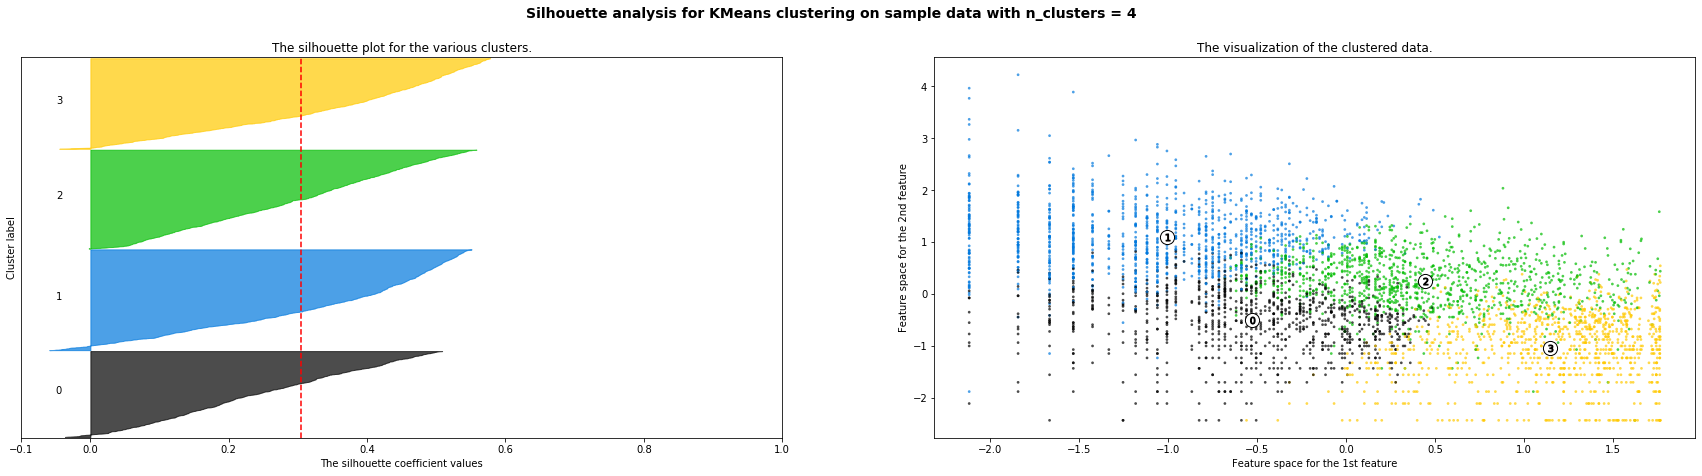

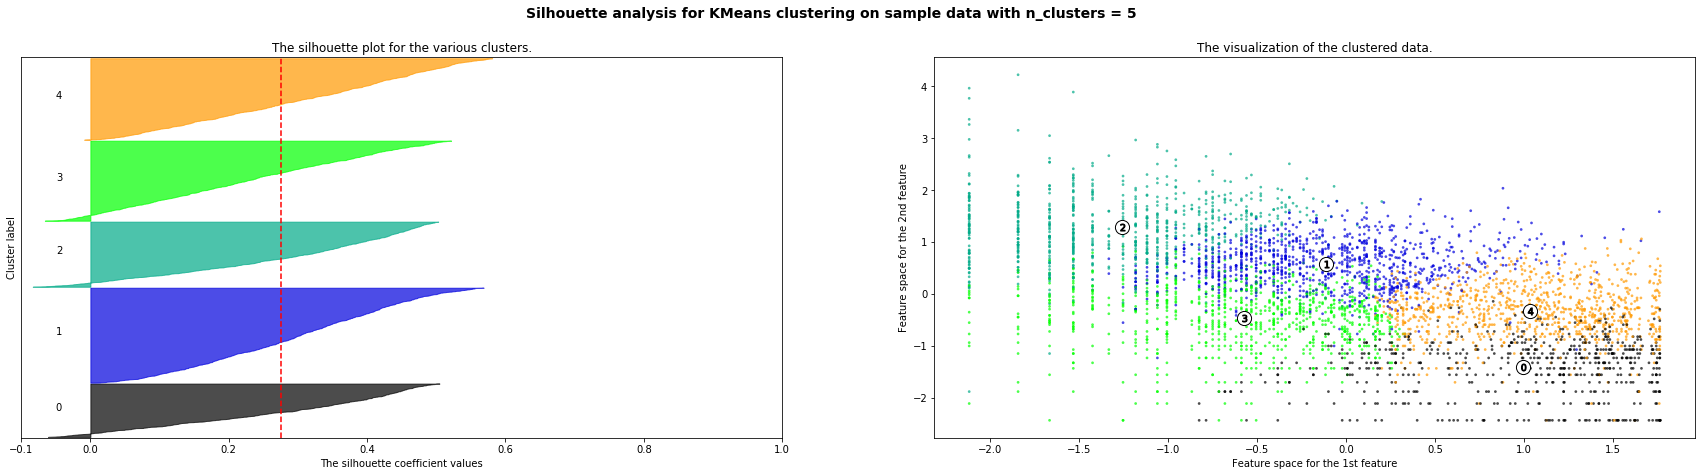

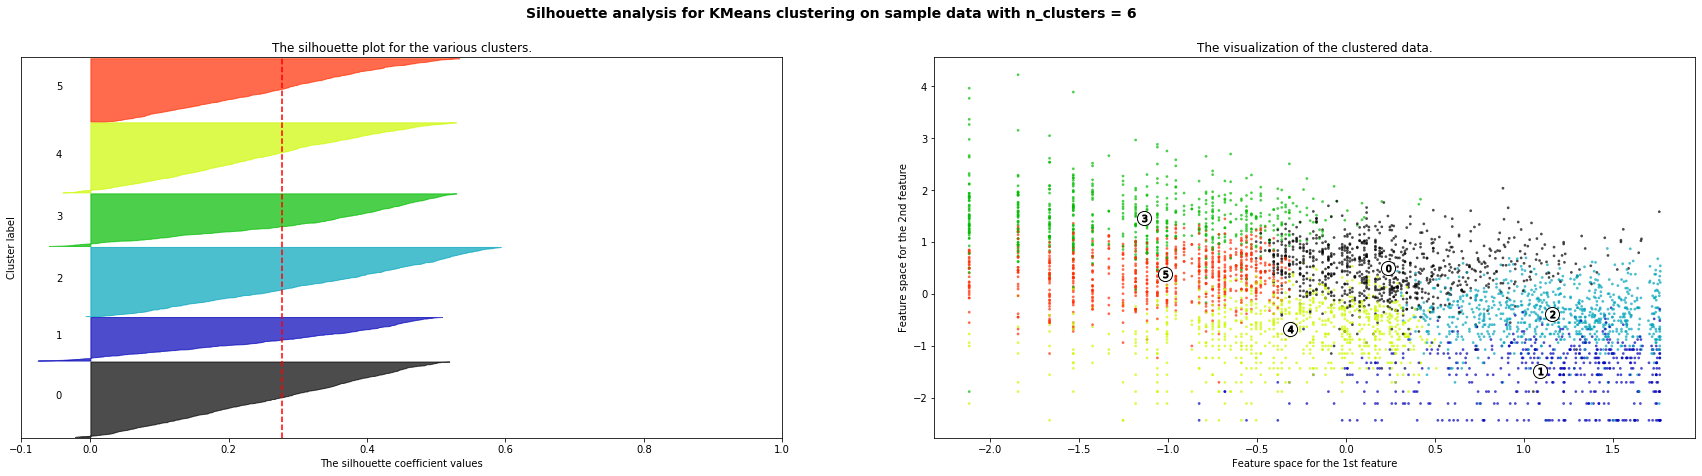

In [84]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(30, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [85]:
# k means using 5 clusters and k-means++ initialization
final_kmean = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++', random_state = 42)
final_kmean.fit(X)
pred = final_kmean.predict(X)

# ----------------------------------------------------------

In [86]:
final = pd.DataFrame(X,columns=['recency','frequency','monetary_value'])
final['cluster'] = pred
final.head()

recency  frequency  monetary_value  cluster
0  1.622693  -2.427183        3.135827        3
1 -1.841787   1.192500        1.391185        1
2  0.289972  -0.317571        0.599632        2
3 -0.680022   0.452261        0.610242        2
4  1.571137  -0.717638       -0.687825        3

In [87]:
final.cluster.value_counts()

2    1122
4     927
3     924
1     781
0     580
Name: cluster, dtype: int64

In [88]:
import plotly.express as px
x_plot = final['recency']
y_plot = final['frequency']
z_plot = final['monetary_value']

fig = px.scatter_3d( x=x_plot, y=y_plot, z=z_plot, color=final['cluster'], size_max=18, opacity=1)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Market Basket Analysis

In [89]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [90]:
## Grouping data 
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket.head()

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                  0.0                             0.0   
536366                                  0.0                             0.0   
536367                                  0.0                             0.0   
536368                                  0.0                             0.0   
536369                                  0.0                             0.0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                      0.0                           0.0   
536366                      0.0                           0.0   
536367                      0.0                           0.0   
536368                      0.0                           0.0   
536369                      0.0                           0.0   

Description   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY  \
InvoiceNo                                                             
536365                                0.0                       0.0   
536366                                0.0                       0.0   
536367                                0.0                       0.0   
536368                                0.0                       0.0   
536369                                0.0                       0.0   

Description   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
InvoiceNo                                                            
536365                               0.0                       0.0   
536366                               0.0                       0.0   
536367                               0.0                       0.0   
536368                               0.0                       0.0   
536369                               0.0                       0.0   

Description   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  ...  \
InvoiceNo                                                               ...   
536365                                    0.0                      0.0  ...   
536366                                    0.0                      0.0  ...   
536367                                    0.0                      0.0  ...   
536368                                    0.0                      0.0  ...   
536369                                    0.0                      0.0  ...   

Description  ZINC STAR T-LIGHT HOLDER   ZINC SWEETHEART SOAP DISH  \
InvoiceNo                                                           
536365                             0.0                        0.0   
536366                             0.0                        0.0   
536367                             0.0                        0.0   
536368                             0.0                        0.0   
536369                             0.0                        0.0   

Description  ZINC SWEETHEART WIRE LETTER RACK  ZINC T-LIGHT HOLDER STAR LARGE  \
InvoiceNo                                                                       
536365                                    0.0                             0.0   
536366                                    0.0                             0.0   
536367                                    0.0                             0.0   
536368                                    0.0                             0.0   
536369                                    0.0                             0.0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
536365                                   0.0                              0.0   
536366                                   0.0                              0.0   
536367                                   0.0                           

In [91]:
## Cleansing values
def clean(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket = basket.applymap(clean)
basket.head()

Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                    0                               0   
536366                                    0                               0   
536367                                    0                               0   
536368                                    0                               0   
536369                                    0                               0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                        0                             0   
536366                        0                             0   
536367                        0                             0   
536368                        0                             0   
536369                        0                             0   

Description   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY  \
InvoiceNo                                                             
536365                                  0                         0   
536366                                  0                         0   
536367                                  0                         0   
536368                                  0                         0   
536369                                  0                         0   

Description   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
InvoiceNo                                                            
536365                                 0                         0   
536366                                 0                         0   
536367                                 0                         0   
536368                                 0                         0   
536369                                 0                         0   

Description   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  ...  \
InvoiceNo                                                               ...   
536365                                      0                        0  ...   
536366                                      0                        0  ...   
536367                                      0                        0  ...   
536368                                      0                        0  ...   
536369                                      0                        0  ...   

Description  ZINC STAR T-LIGHT HOLDER   ZINC SWEETHEART SOAP DISH  \
InvoiceNo                                                           
536365                               0                          0   
536366                               0                          0   
536367                               0                          0   
536368                               0                          0   
536369                               0                          0   

Description  ZINC SWEETHEART WIRE LETTER RACK  ZINC T-LIGHT HOLDER STAR LARGE  \
InvoiceNo                                                                       
536365                                      0                               0   
536366                                      0                               0   
536367                                      0                               0   
536368                                      0                               0   
536369                                      0                               0   

Description  ZINC T-LIGHT HOLDER STARS LARGE  ZINC T-LIGHT HOLDER STARS SMALL  \
InvoiceNo                                                                       
536365                                     0                                0   
536366                                     0                                0   
536367                                     0                           

In [111]:
frequent_item = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_item, metric="lift", min_threshold=0.8).iloc[:,:7]
rules.sort_values(['antecedent support','confidence','lift'], ascending=False).head()

antecedents                         consequents  \
65  (WHITE HANGING HEART T-LIGHT HOLDER)  (RED HANGING HEART T-LIGHT HOLDER)   
66            (REGENCY CAKESTAND 3 TIER)  (ROSES REGENCY TEACUP AND SAUCER )   
10            (REGENCY CAKESTAND 3 TIER)   (GREEN REGENCY TEACUP AND SAUCER)   
16             (JUMBO BAG RED RETROSPOT)           (JUMBO BAG PINK POLKADOT)   
23             (JUMBO BAG RED RETROSPOT)            (JUMBO STORAGE BAG SUKI)   

    antecedent support  consequent support   support  confidence      lift  
65            0.107108            0.036898  0.024726    0.230847  6.256335  
66            0.092544            0.042550  0.022824    0.246624  5.796127  
10            0.092544            0.037550  0.020324    0.219612  5.848492  
16            0.086947            0.047332  0.029671    0.341250  7.209739  
23            0.086947            0.042061  0.023584    0.271250  6.449021